# First Baruch Volatility Workshop
<p>

## Session 4: Fitting SVI

<p>

Instructor: Jim Gatheral   
  
  
<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/07/BaruchLogo2.png" align = "left" width=160></h3>      <h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/07/MFElogo.png" align = "right" width=100></h3>



### Outline of Session 4


- <span>Generating an implied volatility surface from raw index option
data.</span>


- <span>The SVI square root parameterization.</span>


- <span>Fitting SVI subject to no-arbitrage constraints.</span>


- <span>Visualization:</span>

    -   <span>Total variance plot.</span>

    -   <span>3D plot.</span>

    -   <span>Local variance plot.</span>


- Empirical term structure function.


- Extensions and alternatives

### General objective

In this session, we will show how to fit the SVI and SSVI parameterizations of [Gatheral and Jacquier]<sup id="cite_ref-GatheralJacquierSSVI" class="reference"><a href="#cite_note-GatheralJacquierSSVI"><span>[</span>4<span>]</span></a></sup>.</span>

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

download.file(url="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/06/VW4.zip", destfile="VW4.zip")
unzip(zipfile="VW4.zip")



trying URL 'http://mfe.baruch.cuny.edu/wp-content/uploads/2015/06/VW4.zip'
Content type 'application/zip' length 158395 bytes (154 KB)
opened URL
downloaded 154 KB



In [3]:
%%R

source("BlackScholes.R")
source("plotSVI.R")
source("sviJW.R")
source("plotIvols.R")
source("sviarbitrage.R")
source("optionMetricsToIvols.R")
source("sviRoots.R")
source("sviFit0.R")
source("sviSqrtFit.R")
source("computeImpliedVols.R")
source("sviFitQuarticRoots.R")
source("sviVolSurface.R")
source("svi.R")

In [4]:
%%R

sviCalendarArbitrageCheck <- function(sviMatrix){

n <- dim(sviMatrix)[1];
arbtot <- 0;

arbcheck <- function(i){ComputeSviRoots(sviMatrix[i:(i+1),])$crossedness}; # Recall that ComputeSviRoots returns discriminants when there is a true real root.
tmp <- sum(sapply(1:(n-1),arbcheck));

return(tmp);
}

sviSliceArbitrageCheck <- function(sviMatrix){

sviMatrix <- as.data.frame(sviMatrix);
n <- dim(sviMatrix)[1];

g <- function(sviparams,k){

    a <- sviparams$a;
    b <- sviparams$b;
    sig <- sviparams$sig;
    rho <- sviparams$rho;
    m <- sviparams$m;
    
    discr <- sqrt((k-m)*(k-m) + sig*sig);
    w <- a + b *(rho*(k-m)+ discr);
    dw <- b*rho + b *(k-m)/discr;
    d2w <- b*sig^2/(discr*discr*discr);
    
    return(1 - k*dw/w + dw*dw/4*(-1/w+k*k/(w*w)-4) +d2w/2);
}

arbitrageableSlices <- numeric(0);

for (slice in 1:n){
    res <- optimize(function(x){g(sviMatrix[slice,],x)},interval=c(-2,2));
    if(res$objective < 0) {arbitrageableSlices <- c(arbitrageableSlices,slice)};
}

return(arbitrageableSlices);

}


sviSliceArbitrageCompute <- function(sviMatrix){

sviMatrix <- as.data.frame(sviMatrix);
n <- dim(sviMatrix)[1];

g <- function(sviparams,k){

    a <- sviparams$a;
    b <- sviparams$b;
    sig <- sviparams$sig;
    rho <- sviparams$rho;
    m <- sviparams$m;
    
    discr <- sqrt((k-m)*(k-m) + sig*sig);
    w <- a + b *(rho*(k-m)+ discr);
    dw <- b*rho + b *(k-m)/discr;
    d2w <- b*sig^2/(discr*discr*discr);
    
    return(1 - k*dw/w + dw*dw/4*(-1/w+k*k/(w*w)-4) +d2w/2);
}

sliceArb <- NULL;

for (slice in 1:n){
    res <- optimize(function(x){g(sviMatrix[slice,],x)},interval=c(0,2));
    kArb <- res$minimum
    gArb <- min(res$objective,0)
    sliceArb <- rbind(sliceArb,c(slice,kArb,gArb))
}

sliceArb <- as.data.frame(sliceArb)
names(sliceArb) <- c("slice","kMin","gArb")


return(as.data.frame(sliceArb));

}

### Generating implied vols

-   <span>We source raw index option price data from OptionMetrics In
    this case, the data file is spxOptionMetrics.rData.</span>


-   <span>We use the function $generateOptionMetricsIvols$ from
    optionMetricsToIVols.R to generate $spxIvols050915$.</span>


-   <span>We use the function $plotIvols$ from plotIvols.R to plot the
    results.</span>



### Raw data

Raw OptionMetrics price data looks like this:

In [5]:
%%R

load("spxOptionMetrics.rData")

head(spxData050915)

        secid     date symbol symbol_flag   exdate last_date cp_flag
545518 108105 20050915 SPB.FT           0 20060617  20050908       C
545519 108105 20050915 SPB.LT           0 20051217  20050809       C
545520 108105 20050915 SPB.RT           0 20060617  20050830       P
545521 108105 20050915 SPB.XT           0 20051217  20050902       P
545522 108105 20050915 SPL.FA           0 20070616        NA       C
545523 108105 20050915 SPL.FJ           0 20070616        NA       C
       strike_price best_bid best_offer volume open_interest optionid cfadj
545518      1600000      0.0        0.5      0            63 23785632     1
545519      1600000      0.0        0.5      0           170 23956762     1
545520      1600000    340.9      342.9      0           683 23785633     1
545521      1600000    361.5      363.5      0           705 23956761     1
545522       700000    538.3      541.3      0             0 26643070     1
545523       850000    406.1      409.1      0             0 

Note that the strike prices are out by a factor of 1,000!  So let's fix them:

In [6]:
%%R
spxData050915$strike_price <- spxData050915$strike_price/1000 

### Implied volatility computation for index options

-   <span>We compute all implied volatilities from option price
    data</span>

    -   <span>We don’t need external estimates of interest rates and
        dividends</span>


-   <span>We use put-call parity to get implied forward prices and
    discount factors.</span>

    -   <span>Find the unique forward price and discount factor that
        minimize implied forward pricing errors.</span>


-   <span>In this way, we can avoid errors due to non-synchronous
    parameter estimates and typically generate very smooth implied
    volatility curves.</span>

### Detail of forward and PV estimation

We choose the forward and the PV factor for each expiration so as to
minimize the squared error in the put-call parity relationship:

          pvGuess <- 1;
          fGuess <- mean(imid+strikes);
          nearTheMoneyStrikes <- strikes[order(abs(imid))][1:6];
          
          include <- (strikes%in%nearTheMoneyStrikes); 
          obj <- function(params){
            f <- params[1]; pv <- params[2];
            ifit <- pv*(f-strikes); # This is a vector length nk
            errmid <- (ifit-imid)*include;
            return(sum(errmid^2));
          }
          fit <- optim(c(fGuess,pvGuess),obj,method="L-BFGS-B", 
                                                   lower=c(min(strikes),0.5),upper=c(max(strikes),2));
          ffit <- fit$par[1];
      pvfit <- fit$par[2];


### Implied volatility output

The resulting implied volatility output looks like this:


In [7]:
%%R
spxIvols050915  <- generateOptionMetricsIvols(spxData050915)
spxIvols050915[30:50,]

     Expiry        Texp Strike        Bid        Ask      Fwd     CallMid
30 20050917 0.005475702   1150         NA 0.37535440 1227.798          NA
31 20050917 0.005475702   1155         NA 0.32547806 1227.798          NA
32 20050917 0.005475702   1160 0.30490494 0.37678130 1227.798 67.95133827
33 20050917 0.005475702   1165         NA 0.32676025 1227.798          NA
34 20050917 0.005475702   1170 0.26360852 0.34657446 1227.798 58.00243316
35 20050917 0.005475702   1175 0.24285638 0.26499148 1227.798 52.87469594
36 20050917 0.005475702   1180 0.24263809 0.28715960 1227.798 48.00243316
37 20050917 0.005475702   1185         NA 0.23352259 1227.798          NA
38 20050917 0.005475702   1190 0.19745139 0.20977679 1227.798 37.92579083
39 20050917 0.005475702   1195 0.15864560 0.19484019 1227.798 32.92579083
40 20050917 0.005475702   1200 0.16142793 0.17666020 1227.798 28.00243316
41 20050917 0.005475702   1205 0.15018761 0.15579053 1227.798 23.07907550
42 20050917 0.005475702   1210 0.12791

### Implied volatility smiles: September 15, 2005

Finally plot the smiles:

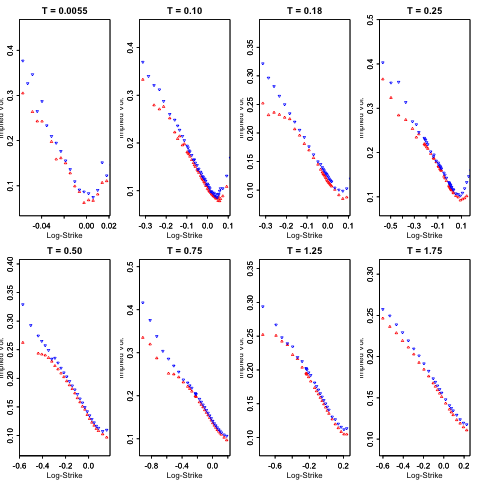

In [8]:
%%R
res05 <- plotIvols(spxIvols050915)

Figure 1: Here are the SPX implied volatility smiles corresponding to the
output

### Single-stock options

-   <span>That’s fine for index options which are European-style. What
    about single-stock options which are American-style? </span>


-   <span>We can’t use the same put-call parity trick we used before to
    impute forwards and PV factors.</span>


-   <span>In principle, we have to take the whole volatility surface
    into account when pricing American options.</span>


-   <span>Ignoring this however, given some American option model that
    takes discrete dividends as an input, we can impute interest rates
    and borrow costs for single-stocks.</span>

    


### SVI parameters used in *The Volatility Surface*

Here are the SVI parameters corresponding to the SVI fit shown in
Figures 3.2 and 3.3 of *The Volatility Surface*:



In [9]:
%%R

texp <- sort(unique(spxIvols050915$Texp))

svidata <- c(
 c(-0.0001449630, 0.0092965440, 0.0196713280, -0.2941176470,-0.0054273230),
 c(-0.000832134	, 0.024439766 , 0.069869455 , -0.299975308 , 0.02648364  ), 
 c(-0.0008676750, 0.0282906450, 0.0873835580, -0.2892204290, 0.0592703000), 
 c(-0.0000591593, 0.0331790820, 0.0812872370, -0.3014043240, 0.0652549210),
 c(0.0011431940	, 0.0462796440, 0.1040682980, -0.3530782140, 0.0942000770), 
 c(0.0022640980	, 0.0562604150, 0.1305339330, -0.4387409470, 0.1111230690), 
 c(0.0040335530	, 0.0733707550, 0.1707947600, -0.4968970370, 0.1496609160), 
 c(0.0034526910	, 0.0917230540, 0.2236814130, -0.4942213210, 0.1854128490));

sviMatrix <- as.data.frame(t(array(svidata,dim=c(5,8))));
colnames(sviMatrix)<-c("a","b","sig","rho","m")

# Inspect the matrix
sviMatrix

              a           b        sig        rho            m
1 -0.0001449630 0.009296544 0.01967133 -0.2941176 -0.005427323
2 -0.0008321340 0.024439766 0.06986945 -0.2999753  0.026483640
3 -0.0008676750 0.028290645 0.08738356 -0.2892204  0.059270300
4 -0.0000591593 0.033179082 0.08128724 -0.3014043  0.065254921
5  0.0011431940 0.046279644 0.10406830 -0.3530782  0.094200077
6  0.0022640980 0.056260415 0.13053393 -0.4387409  0.111123069
7  0.0040335530 0.073370755 0.17079476 -0.4968970  0.149660916
8  0.0034526910 0.091723054 0.22368141 -0.4942213  0.185412849


### Equivalent SVI-JW parameters.

We note that for longer expirations, JW parameters are almost
independent of expiration:

In [10]:
%%R
sviToJw(sviMatrix,texp)

           vt        psit        pt        ct     varmint        texp
1 0.005461444 -0.02393127 2.1999949 1.1999972 0.005446544 0.005475702
2 0.011729194 -0.23199502 0.9217058 0.4963300 0.007865899 0.101300479
3 0.014634977 -0.23575331 0.7146813 0.3940218 0.008422155 0.177960301
4 0.015913797 -0.24169930 0.6783336 0.3641304 0.009867464 0.254620123
5 0.018220317 -0.24736379 0.6536137 0.3125000 0.011214052 0.503764545
6 0.019460020 -0.25260651 0.6687175 0.2608696 0.011772234 0.752908966
7 0.020901180 -0.26222826 0.6791513 0.2282609 0.011915278 1.251197810
8 0.022010229 -0.26465446 0.6984348 0.2364130 0.012168504 1.749486653


### SVI fit example: September 15, 2005

Now check the quality of the SVI fit:

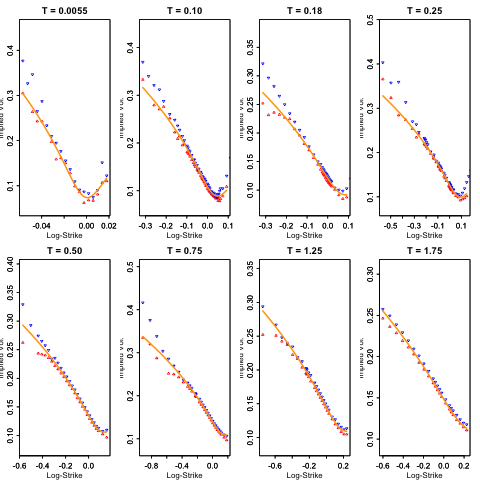

In [11]:
%%R
res05 <- plotIvols(spxIvols050915,sviMatrix);

Figure 2: This fit is the one shown in Figure 3.3 of *The Volatility
Surface*

### Comments on the SVI fit

-   <span>It’s hard to deny that this SVI fit is strikingly good.</span>

    -   <span>At least in this particular case, the SVI parameterization
        gives an arbitrage-free surface with very good fits to the data.
        </span>


-   <span>We would like to achieve a similar fit quality using only
    simple code written in R.</span>

### SPX total variance plot as of 15-Sep-2005

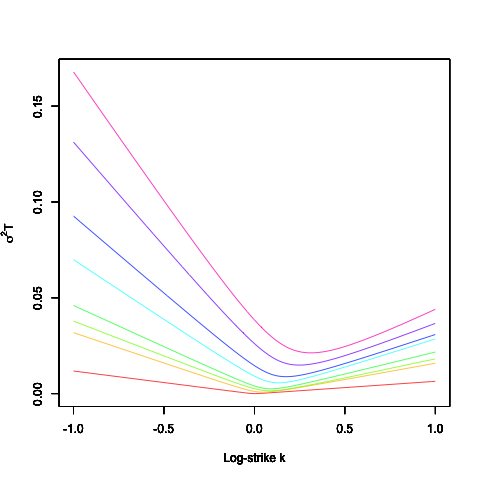

In [12]:
%%R
plotSVI(sviMatrix)

Figure 3: SVI fits to the SPX implied volatility surface as of the close on
September 15, 2005, the day before triple witching.

### SPX total variance plot as of 15-Sep-2005: zoomed version

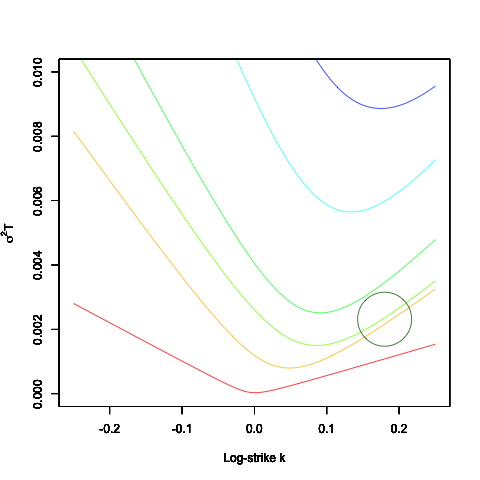

In [13]:
%%R

plotSVI(sviMatrix,xrange=c(-.25,.25),yrange=c(0,0.01))

# Add a circle around the area of interest
y19 <- svi(sviMatrix[2,],.19)
points(x=.18,y=y19,pch=1,cex=10,pty=2,col="dark green")

Figure 4: A zoomed view of the same plot showing lines getting very close to
each other: small local variances!

### The total variance plot: observations

-   <span>Note that none of the lines cross: $w$ is a non-decreasing
    function of $t$ for every log-strike $k$</span>

-   <span>No calendar spread arbitrage is equivalent to no lines
    crossing.</span>

    -   <span>Negative calendar spreads (lines crossing) are equivalent
        to negative local variances</span>

    -   <span>Recall that (equation (1.6) on page 11 of <span>[The Volatility Surface]<sup id="cite_ref-TVS" class="reference"><a href="#cite_note-TVS"><span>[</span>1<span>]</span></a></sup>):
        $$v_{loc}(k,T)=\frac{\partial_T C}{\frac{1}{2}\,K^2\,\partial_{K,K} C}$$
        </span>

    -   <span>Lines moving together mean low local variance</span>

    -   <span>Lines moving apart mean high local variance</span>

### Stineman interpolation

-   <span>Monotonic spline interpolation is essential. Stineman spline
    is a particularly attractive choice.</span>

-   <span>Here’s the term structure of total variance at constant $k=0.19$
    (red is cubic spline, blue is Stineman spline):

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/10/svi2008stineman.png", align="left" width=600></h3>

Figure 5: We see that the cubic spline generates local variances that
    are too small – they can even go negative.</span>

### Fitting SVI slice-by-slice

Fitting slice-by-slice is not a good idea.  Let's see why:

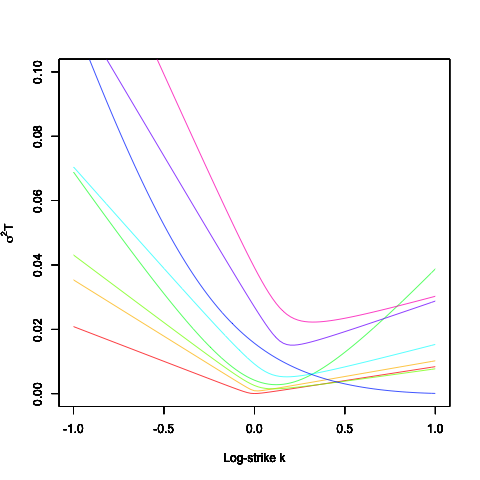

In [14]:
%%R

spxOptData <- spxIvols050915

# Fit each slice individually
fit0 <- sviFit(spxOptData)
plotSVI(fit0,yrange=c(0,.1))

Figure 6: If we fit the slices independently, we see arbitrage
everywhere!

But fits to each slice of course look good...

$expiries
[1] 0.005475702 0.101300479 0.177960301 0.254620123 0.503764545 0.752908966
[7] 1.251197810 1.749486653

$atmVol
[1] 0.07533174 0.10928402 0.11988351 0.12567828 0.13480585 0.13956347 0.14513026
[8] 0.14926899

$atmSkew
[1] -0.7987708 -0.7411599 -0.5534874 -0.4727589 -0.3427874 -0.3040462 -0.2436678
[8] -0.2052787



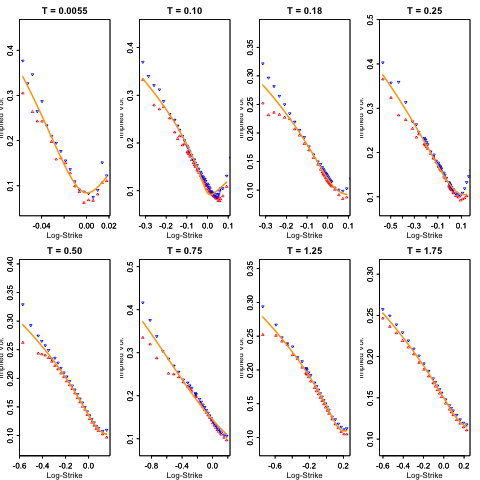

In [15]:
%%R
plotIvols(spxOptData,fit0)

Figure 7: ...but fits to individual slices are good

### Fitting with no calendar spread arbitrage

-   <span>To achieve a fit with no calendar spread arbitrage:</span>

    -   <span>We need to find explicit constraints on the
        parameters.</span>

    -   <span>We need a good initial guess.</span>

### The SVI square root parameterization

Consider the following special case of SSVI:

<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
SVI square-root parameterization</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>

$$
w(k,\theta_t)
= \frac{\theta_t}{2}\left\{1+\rho\varphi(\theta_t) k + \sqrt{\left(\varphi(\theta_t){k}+\rho\right)^2
+(1-\rho^2 })\right\}$$ with
$$\varphi(\theta)=\frac{\eta}{\sqrt{\theta}}.$$

<br>

</div>

</blockquote>


- The SVI square-root parameterization is free of static arbitrage for up
to some (very long in practice) expiration.

### Square-root fit example: September 15, 2005

$expiries
[1] 0.005475702 0.101300479 0.177960301 0.254620123 0.503764545 0.752908966
[7] 1.251197810 1.749486653

$atmVol
[1] 0.07533174 0.10928402 0.11988351 0.12567828 0.13480585 0.13956347 0.14513026
[8] 0.14926899

$atmSkew
[1] -0.7987708 -0.7411599 -0.5534874 -0.4727589 -0.3427874 -0.3040462 -0.2436678
[8] -0.2052787



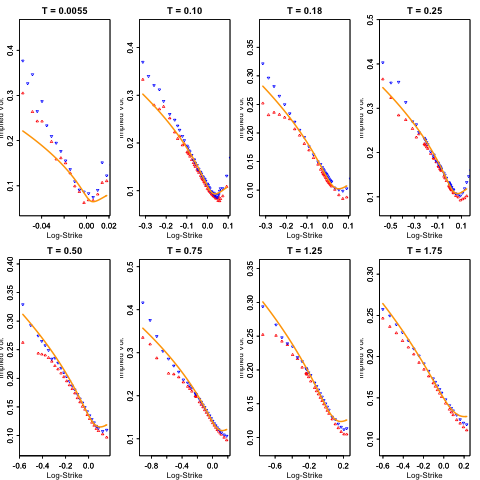

In [16]:
%%R

texp <- unique(spxOptData$Texp)
fitSqrt <- sviSqrtFit(spxOptData)
plotIvols(spxOptData,fitSqrt)

Figure 8: SVI square-root fits surprisingly well! ... except for the front
month.

And here's the total variance plot:

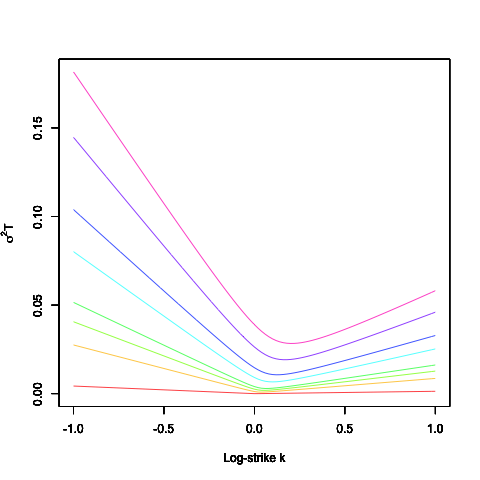

In [17]:
%%R
plotSVI(fitSqrt)

Figure 9: ... and there is no calendar spread arbitrage

### Quote-driven vs order-driven markets

-   <span>In quote-driven markets, we have tight bid-offer prices for
    all listed options. Our fit must necessarily go through all of the
    bids and offers. </span>


-   <span>In order-driven markets, it’s not so clear what the current
    market price of an option is:</span>

    -   <span>We may have a bid with no ask</span>

    -   <span>Or an ask with no bid.</span>

    -   <span>Or neither a bid nor an ask.</span>

    -   <span>Or the bid-ask spread may just be very wide.</span>

-   <span>In order-driven options markets therefore, the square-root fit
    may be more than adequate – even preferable because it has so few
    parameters and is therefore very robust.</span>


-   <span>In quote-driven markets, we need to do better than the
    square-root fit.</span>

### Quantifying lines crossing

- Consider two SVI slices with parameters $\chi_1$ and $\chi_2$ where
$t_2>t_1$.

- We first compute the points $k_i$ $(i=1,\ldots,n)$ with $n\leq 4$ at
which the slices cross, sorting them in increasing order. If $n>0$, we
define the points $\widetilde k_i$ as

\begin{eqnarray*}
\widetilde k_1&:=&k_1-1,\\
\widetilde k_i&:=&\frac 12\,(k_{i-1}+k_{i}),\quad \text{if } 2 \leq i \leq n, \\
\widetilde k_{n+1}&:=&k_n+1.
\end{eqnarray*}

- For each of the $n+1$ points $\widetilde k_i$, we compute the amounts
$c_i$ by which the slices cross:

$$c_i=\max\left[0,w(\widetilde k_i,\chi_1)-w(\widetilde k_i,\chi_2)\right].$$

### Crossedness

<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
Definition 4.4</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>

The <span>*crossedness*</span> of two SVI slices is
defined as the maximum of the $c_i$ $ (i=1,\ldots,n)$. If $n=0$, the
crossedness is null.

<br>

<br>

</div>

</blockquote>

### Computing crossedness

Recall that wwo total variance slices cross if

\begin{eqnarray*}
&& a_1 + b_1\left\{\rho_1 \left(k - m_1\right)  + \sqrt{\left(k - m_1\right)^2 +\sigma^2_1}\right\}\\
&=& a_2 + b_2\left\{\rho_2 \left(k -m_2\right) + \sqrt {\left(k - m_2\right)^2+\sigma^2_2 }\right\}
\end{eqnarray*}
</span>

Rearranging and squaring gives a quartic polynomial equation of the form

$$\alpha_4\,k^4+\alpha_3\,k^3+\alpha_2\,k^2+\alpha_1\,k+\alpha_0=0,$$

where each of the coefficients are lengthy yet explicit expressions in
terms of the raw SVI parameters.</span>

These coefficients are computed in the function ComputeSviRoots in sviRoots.R.


In [18]:
%%R

ComputeSviRoots

function(svi.data){
  # Finds roots and computes crossedness of two SVI slices.
  #
  # Args:
  #  svi.data: A data.frame with two SVI total variance slices in the rows, the earlier 
  #  slice in row 1, the later slice in row 2.  The columns are {a,b,sigma,rho,m}.
  #
  # Returns:
  #   A list with the positions of the points where the lines cross and the crossedness of the two slices.
  
  a1 <- svi.data$a[1] 
  b1 <- svi.data$b[1] 
  s1 <- svi.data$sig[1] 
  r1 <- svi.data$rho[1] 
  m1 <- svi.data$m[1] 

  a2 <- svi.data$a[2] 
  b2 <- svi.data$b[2] 
  r2 <- svi.data$rho[2] 
  m2 <- svi.data$m[2] 
  s2 <- svi.data$sig[2] 

  # The standard form of the quartic is q4 x^4 + q3 x^3 +q2 x^2 +q1 x + q0 == 0
  # Note that multiplying all the coefficients qi by a factor should have no effect on the roots.

  q2 <- 1000000 * -2 * (-3 * b1 ^ 4 * m1 ^ 2 + b1 ^ 2 * b2 ^ 2 * m1 ^ 2 + 4 * b1 ^ 2 * b2 ^ 2 * m1 * m2 + 
            b1 ^ 2 * b2 ^ 2 * m2 ^ 2 - 3 * b2 ^ 4 * m2 ^ 2 + 6 * b1 ^ 4 * m1 ^ 2 

### Example of crossedness computation

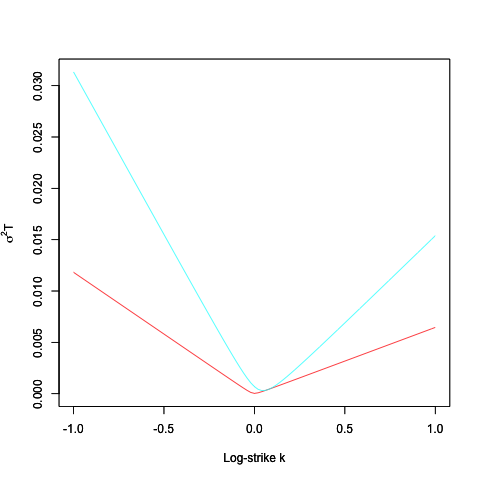

In [19]:
%%R
# Make the lines cross
svi2 <- sviMatrix[1:2,]
svi2$a[2] <- svi2$a[2]-0.0005
plotSVI(svi2)

Figure 10: We lower slice 2 in order to introduce calendar spread arbitrage (crossed lines).

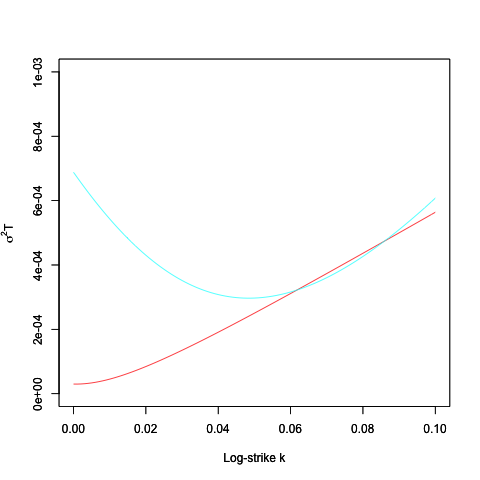

In [20]:
%%R
# Zoom in to the problem area
plotSVI(svi2,xrange=c(0,0.1),yrange=c(0,0.001))

Figure 11: Zoomed version of Figure 10.

Calling ComputeSviRoots() on these two slices gives:

In [21]:
%%R
ComputeSviRoots(svi2)

$roots
[1] 0.06175203 0.08590506

$crossedness
[1] 1.402099e-05



## QR fit

Finally, using *fitSqrt* as an initial guess, change SVI parameters slice-by slice, working backwards, so as to minimize the sum of squared distances between the fitted prices and the mid option prices with a big penalty for crossing either the previous slice or the next slice (as quantified by the crossedness).

In [22]:
%%R

sviFitQR

function(ivolData,sviGuess,penaltyFactor=100){

callVals <- as.numeric(ivolData$CallMid);
askVols <- as.numeric(ivolData$Ask);
bidVols <- as.numeric(ivolData$Bid);
midVols <- (bidVols+askVols)/2;
volSpreads <- (askVols-bidVols)/2;

expDates <- unique(ivolData$Texp);
nSlices <- length(expDates);
slices <- 1:nSlices;
sviMatrix <- sviGuess;

######################################
#for (slice in rev(slices)){  # Start from the latest slice

for (slice in slices){  # Start from the earliest slice

t <- expDates[slice];
texp <- ivolData$Texp;

midVal <- callVals[texp==t];

pick <- !is.na(midVal);
midVal <- midVal[pick];
midVols1 <- midVols[texp==t][pick];
volSpreads1 <- volSpreads[texp==t][pick];
f <- (ivolData$Fwd[texp==t])[1];
k <- log(ivolData$Strike[texp==t]/f)[pick]; # Plot vs log-strike

# Compute squared distance between actual mid-price and theoretical mid-price
sqDist <- function(sviparams){

    tmp1 <- as.list(sviparams);
    names(tmp1) <- c("a","b","sig","rho","m")# tmp1 is w-st

### Example: Fit to 15-Sep-2005 data

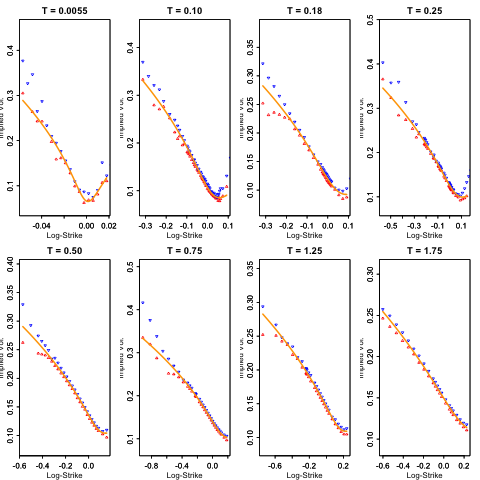

In [23]:
%%R

fitQR <- sviFitQR(spxOptData,fitSqrt)

res <- plotIvols(spxOptData,fitQR)

Figure 12: fitQR slice-by-slice fit quality

Let's check one of the slices:

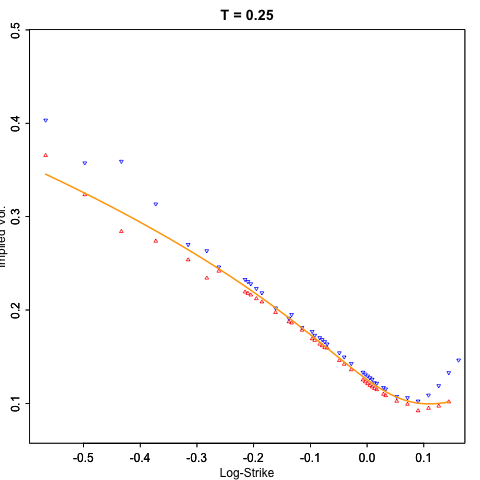

In [24]:
%%R
res <- plotIvols(spxOptData,fitQR,slices=4)

Figure 13: SPX Dec-2011 option quotes as of 3pm on 15-Sep-2011. Red triangles are bid implied volatilities; blue triangles are offered implied volatilities; the
orange solid line is the QR SVI fit (*fitQR*).

And now for the total variance plot:

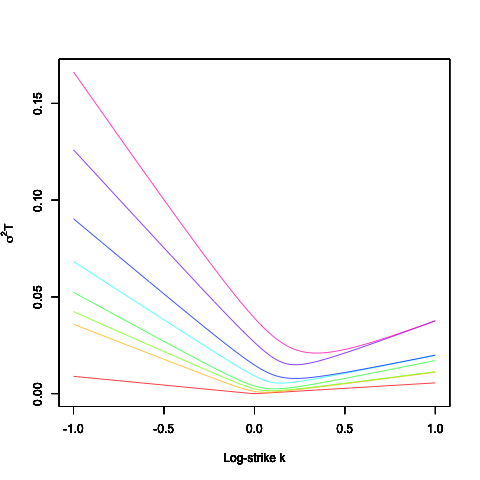

In [25]:
%%R
plotSVI(fitQR)

Figure 14: *fitQR* total variance plot: No calendar spread arbitrage!

### Total variance plot as of 15-Sep-2005

However, it does look as if there are some very small local variances...

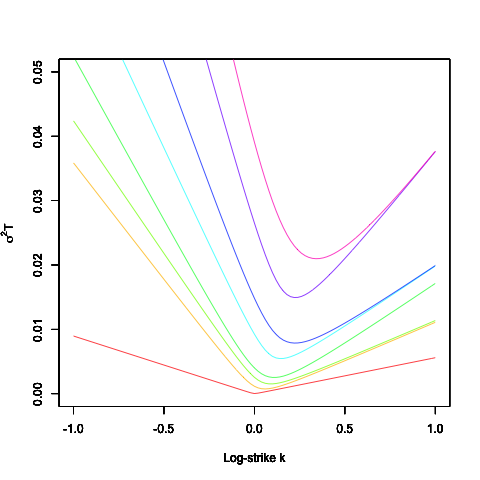

In [26]:
%%R
plotSVI(fitQR,yrange=c(0,0.05))

Figure 15: Closeup of the *fitQR* total variance plot: No calendar spread arbitrage, but very close...

### Check the SVI fit for calendar spread arbitrage


In [27]:
%%R

print(sviCalendarArbitrageCheck(sviMatrix)) # The pre-cooked fit
print(sviCalendarArbitrageCheck(fit0)) # The fit slice-by-slice
print(sviCalendarArbitrageCheck(fitSqrt)) # The sqrt fit
print(sviCalendarArbitrageCheck(fitQR)) # The final optimized fit

[1] 0
[1] 0.1272942
[1] 0
[1] 0


and then for butterfly arbitrage:

In [28]:
%%R

print(sviSliceArbitrageCheck(sviMatrix))
print(sviSliceArbitrageCheck(fit0))
print(sviSliceArbitrageCheck(fitSqrt))
print(sviSliceArbitrageCheck(fitQR))

numeric(0)
[1] 1
numeric(0)
numeric(0)


### Summary of the calibration recipe



-   Given mid implied volatilities
    $\sigma_{ij}=\sigma_{{\rm BS}}(k_i,t_j)$, compute mid option prices
    using the Black-Scholes formula.



-   Fit the square-root SVI surface by minimizing sum of squared
    distances between the fitted prices and the mid option prices. This
    is now the initial guess.



-   Starting with the square-root SVI initial guess, change SVI
    parameters slice-by slice so as to minimize the sum of squared
    distances between the fitted prices and the mid option prices with a
    big penalty for crossing either the previous slice or the next slice
    (as quantified by the crossedness from
    [Definition 4.4](#def:crossedness)).




###QR fit vs pre-cooked fit

Finally, let's compare the pre-cooked surface with *fitQR*:

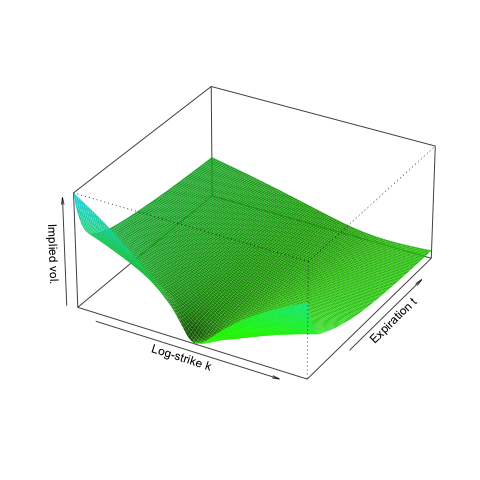

In [29]:
%%R
volTVS <- function(k,t){sqrt(sviW(sviMatrix,texp,k,t)/t)}
  
# 3D plot of TVS volatility surface
    k <- seq(-.5,.5,0.01) # Vector of log-strikes
    t <- seq(0.04,1.74,0.02) # Vector of times
    z <- t(volTVS(k,t)); # Array of volatilities
    
    # Add colors
    nbcol <- 100;
    color <- rainbow(nbcol,start=.3,end=.5);
    nrz <- nrow(z)
    ncz <- ncol(z)
    # Compute the z-value at the facet centres
    zfacet <- z[-1, -1] + z[-1, -ncz] + z[-nrz, -1] + z[-nrz, -ncz]
    # Recode facet z-values into color indices
    facetcol <- cut(zfacet, nbcol);
    
    # Generate 3D plot
    persp(k, t, z, col=color[facetcol], phi=30, theta=30, 
        r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=20,ticktype="simple",
        shade=.8,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied vol.");

Figure 16: 3D plot of the pre-cooked SVI fit to the SPX implied volatilities as of September
15, 2005

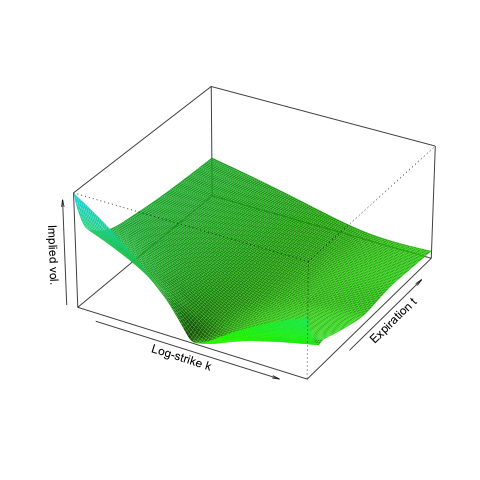

In [30]:
%%R
volTVS <- function(k,t){sqrt(sviW(fitQR,texp,k,t)/t)}
  
# 3D plot of TVS volatility surface
    k <- seq(-.5,.5,0.01) # Vector of log-strikes
    t <- seq(0.04,1.74,0.02) # Vector of times
    z <- t(volTVS(k,t)); # Array of volatilities
    
    # Add colors
    nbcol <- 100;
    color <- rainbow(nbcol,start=.3,end=.5);
    nrz <- nrow(z)
    ncz <- ncol(z)
    # Compute the z-value at the facet centres
    zfacet <- z[-1, -1] + z[-1, -ncz] + z[-nrz, -1] + z[-nrz, -ncz]
    # Recode facet z-values into color indices
    facetcol <- cut(zfacet, nbcol);
    
    # Generate 3D plot
    persp(k, t, z, col=color[facetcol], phi=30, theta=30, 
        r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=20,ticktype="simple",
        shade=.8,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied vol.");

Figure 17: 3D plot of the QR fit to the SPX implied volatilities as of September
15, 2005

Note that the QR fit looks almost as good as the pre-cooked one.

### Choice of objective function

-   <span>A $0.1\%$ volatility error on an ATM option is a much bigger
    pricing error than on a very far out-of-the-money option.</span>


-   <span>Practitioners take this into consideration by vega-weighting
    their fits.</span>


-   <span>From the Black-Scholes formula:
    $$\mathrm{vega} = \sqrt{T}\,K\,\frac{e^{-d_2^2/2}}{\sqrt{2\,\pi}} = \sqrt{T}\,F\,\frac{e^{-d_1^2/2}}{\sqrt{2\,\pi}}$$
    </span>


-   <span>Alternatively, weight by the reciprocal of the bid-ask
    volatility spread as in our implementation.</span>

### Now we repeat the whole calibration recipe for 15-Sep-2011

In [31]:
%%R
head(spxData110915)

         secid     date             symbol symbol_flag   exdate last_date
2559920 108105 20110915  SPX 110917C100000           1 20110917  20110815
2559921 108105 20110915 SPX 110917C1000000           1 20110917  20110915
2559922 108105 20110915 SPX 110917C1005000           1 20110917  20110829
2559923 108105 20110915 SPX 110917C1010000           1 20110917  20110829
2559924 108105 20110915 SPX 110917C1015000           1 20110917  20110912
2559925 108105 20110915 SPX 110917C1020000           1 20110917  20110909
        cp_flag strike_price best_bid best_offer volume open_interest optionid
2559920       C       100000   1106.4     1110.0      0             0 49587202
2559921       C      1000000    206.4      210.0     22          4213 49287956
2559922       C      1005000    200.2      204.1      0            11 63098880
2559923       C      1010000    195.2      199.1      0             5 63098881
2559924       C      1015000    190.2      194.1      0             5 63098882
2559925 

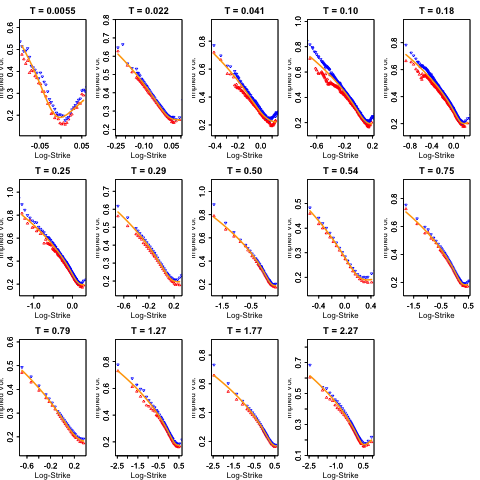

In [32]:
%%R

spxData110915$strike_price <- spxData110915$strike_price/1000
spxIvols110915 <- generateOptionMetricsIvols(spxData110915)
fitSqrt110915 <- sviSqrtFit(spxIvols110915)
fitQR110915 <- sviFitQR(spxIvols110915,fitSqrt110915)
res110915 <- plotIvols(spxIvols110915,fitQR110915)


Figure 18: SPX option quotes as of 3pm on 15-Sep-2011. Red triangles are bid
implied volatilities; blue triangles are offered implied volatilities;
the orange solid line is the quartic roots (QR) SVI fit.

### QR fit: December 2011 detail

$expiries
 [1] 0.005475702 0.021902806 0.041067762 0.101300479 0.177960301 0.254620123
 [7] 0.290212183 0.503764545 0.539356605 0.752908966 0.788501027 1.270362765
[13] 1.768651608 2.266940452

$atmVol
[1] 0.0000000        NA        NA        NA        NA        NA 0.2853402

$atmSkew
[1]  0.0000000         NA         NA         NA         NA         NA -0.5458074



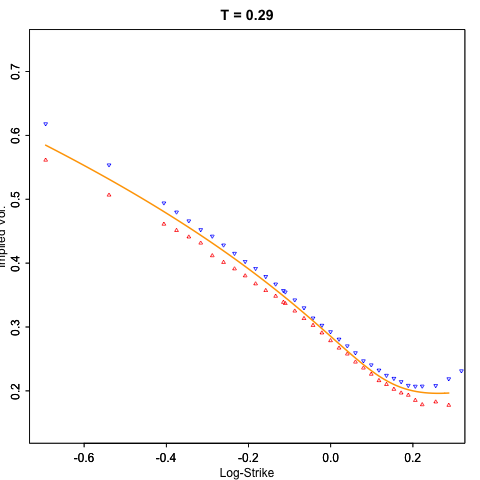

In [33]:
%%R

plotIvols(spxIvols110915,fitQR110915,slices=7)

Figure 19: SPX Dec-2011 option quotes as of 3pm on 15-Sep-2011. Red triangles are
bid implied volatilities; blue triangles are offered implied
volatilities; the orange solid line is the quartic roots SVI
fit

### QR fit: March 2012 detail

$expiries
 [1] 0.005475702 0.021902806 0.041067762 0.101300479 0.177960301 0.254620123
 [7] 0.290212183 0.503764545 0.539356605 0.752908966 0.788501027 1.270362765
[13] 1.768651608 2.266940452

$atmVol
[1] 0.0000000        NA        NA        NA        NA        NA        NA
[8] 0.2792849

$atmSkew
[1]  0.000000        NA        NA        NA        NA        NA        NA
[8] -0.411406



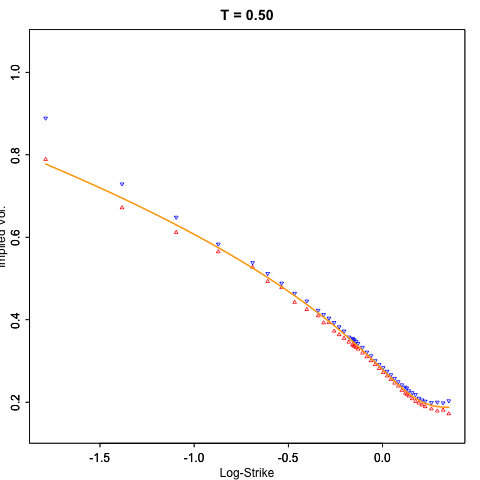

In [34]:
%%R
plotIvols(spxIvols110915,fitQR110915,slices=8)

Figure 21: SPX Mar-2012 option quotes as of the close on 15-Sep-2011. Red
triangles are bid implied volatilities; blue triangles are offered
implied volatilities; the orange solid line is the SVI
fit

### SVI local variance

$$
\newcommand{\BS}{\text{BS}}
$$
Recall the Dupire equation for local variance:

\begin{equation}
\sigma ^2(K,T,S_0)\,=\,\frac { \frac{{\partial C}}{{\partial T}}}
{ \frac{{1 }}{2}\,\,K^2\,\frac{{\partial ^2 C}}{{\partial K^2 }}}
\end{equation}

where $C$ represents a European option price, or equivalently in term of implied volatility (see equation (1.10) in [The Volatility Surface]):

<a name="eq12:localfromimplied"></a>(12)
\begin{equation}
v_\ell(k,T) = \frac{\frac{\partial w}{\partial T}}
{\left(1 -\frac 12\frac{k}{w}\,\frac{\partial w}{\partial k}\right)^2
 - \frac14\,\left( \frac{1}{4} + \frac{1}{w} \right)\,
 \left( \frac{\partial w}{\partial k} \right)^2  +
\frac{1}{2}\,\frac{\partial^2 w}{\partial k^2 }}
\end{equation}

where $w(k,T) = \sigma_{\BS}^2(k,T)$ is implied total variance.


- The local variance surface $v_\ell(k,T)$ is given uniquely by equation [(12)](#eq12:localfromimplied) provided that we have a functional form $w(k,T)$ for implied total variance that is free of static arbitrage.

    - This is one of the main applications of the SVI parameterization.

We now examine the local volatility surface generated by the QR fit.  First, we need a function implementing the Dupire equation to compute local variance.

### Function to compute SVI local variance

First we need an interpolation function to get total variance given k and t:

In [35]:
%%R

# texp is a vector of times to expiration
sviW <- function(sviMatrix,texp,k,t){

    # Vector of SVI variance for a given strike k
    sviWk <- function(k){
        m <- dim(sviMatrix)[1]
        sapply(1:m,function(i){svi(sviMatrix[i,],k)})
    }

    # Function to compute interpolated variance for any strike and expiration
    wInterp <- function(k,t){stinterp(texp,sviWk(k),t)$y}

    # Vectorized function that returns implied total variance for vectors k and t
    return(sapply(k,function(k1){wInterp(k1,t)}))

} 

Here is a function to compute local variance using finite differences

In [36]:
%%R

sviLocalVar <- function(sviMatrix,texp,k,t){

    deltak <- 0.001
    deltat <- 0.001*(t>0.001)+t/2*(t<=0.001) # Make sure we don't end up with negative times!
    
    # Estimate derivatives
    wkt <- sviW(sviMatrix,texp,k,t); 
    wktm <- sviW(sviMatrix,texp,k,t-deltat); 
    wktp <- sviW(sviMatrix,texp,k,t+deltat);
    dwdt <- (wktp-wktm)/(2*deltat);# Central difference!
    wkmt <- sviW(sviMatrix,texp,k-deltak,t);
    wkpt <- sviW(sviMatrix,texp,k+deltak,t);
    dwdk <- (wkpt-wkmt)/(2*deltak);
    d2wdk2 <- (wkpt+wkmt-2*wkt)/(deltak^2);

    tmp <- dwdt/(1 - k/wkt*dwdk + 1/4*(-1/4 - 1/ wkt + k^2/wkt^2)*(dwdk)^2 + 1/2*d2wdk2);

    return(tmp);

}

### Example

In [37]:
%%R

texp110915 <- res110915$expiries
sviLocalVar(fitQR110915,texp110915,c(-.2,.2),0.04)

[1] 0.59340731 0.02106055


### 3D plot of local variance surface

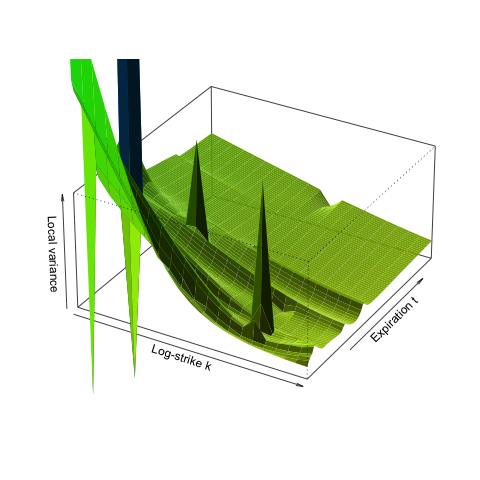

In [38]:
%%R

k <- seq(-.2,.2,.02) # Vector of log-strikes
t <- seq(0.04,1.72,0.02) # Vector of times

z <- sapply(t,function(tt){sviLocalVar(fitQR110915,texp110915,k,tt)})

# Add colors
nbcol <- 100;
color <- rainbow(nbcol,start=.2,end=.6);
nrz <- nrow(z)
ncz <- ncol(z)
# Compute the z-value at the facet centres
zfacet <- z[-1, -1] + z[-1, -ncz] + z[-nrz, -1] + z[-nrz, -ncz]
# Recode facet z-values into color indices
facetcol <- cut(zfacet, nbcol);

# Generate 3D plot
persp(k, t, z, col=color[facetcol], phi=30, theta=30, 
    r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=20,ticktype="simple",
    shade=.8,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Local variance",zlim=c(0,.2));

Figure 22: Local variance surface from full SVI fit (fitQR).

###Analysis of historical SPX volatility surface data
$$
\newcommand{\BS}{\text{BS}}
$$
Recall that $\theta_t=\sigma^2_{\BS}(0,t)\,t$ and that the ATM volatility skew is given by

$$
\left.\partial_k \sigma_{\BS}(k,t)\right|_{k=0}
=\frac{\rho\sqrt{\theta_t}}{2\sqrt{t}}\varphi(\theta_t)
$$
so that

$$
\rho\,\varphi(\theta_t) =\left.\partial_k \log\left( \sigma_{\BS}(k,t)^2\,t\right)\right|_{k=0}.
$$

- Thus $\theta_t$ and $\varphi_t$ may be determined empirically from robust estimates of ATM volatility and ATM skew.


###Log-log plot of empirical SPX $\rho \varphi$ vs $\theta$ 


<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/05/logThetaLogPhi.png", align="left" width=900></h3>


Figure 23: $\log(\varphi)$ vs $\log(\theta)$ for each of the $2,616$ days in the sample superimposed.  Points are color-coded with dates ranging from red via blue to violet. 

###Log-log plot of empirical SPX $\rho \varphi$ rescaled by $\varphi_{SPX}$ vs $\theta$ 

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/05/Rescaled.png", align="left" width=900></h3>


<a name="fig:Rescaled"></a>Figure 24: $\log(\varphi/\varphi_{SPX})$ vs $\log(\theta)$ for each of the $2,616$ days in the sample superimposed.

###Remarks on [Figure 24](#fig:Rescaled).

- The scatter plot looks flat


- On average, it looks as if the empirical $\varphi$ is equal to $\varphi_{SPX}$.



- Let's check with kernel regression...

###Kernel regression

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/05/KernelRegression.png", align="left" width=900></h3>

Figure 25: Kernel regression of [Figure 24](#fig:Rescaled). data. The LH plot shows the data and regression line.  The RH plot shows how flat the line is and that it is mean zero.

###SSVI fits to historical SPX options data

Our dataset consists of roughly 2,600 days of SPX option closing prices from OptionMetrics.

- We fit the function 

$$
w(k,\theta_t)
= \frac{\theta_t}{2}\left\{1+\rho\,\varphi(\theta_t) k + \sqrt{\left(\varphi(\theta_t){k}+\rho\right)^2
+(1-\rho^2 })\right\}
$$

with

$$
\varphi(\theta)= \frac{\eta}{\theta^{\gamma_1}\,(1+\beta_1\,\theta)^{\gamma_2}\,(1+\beta_2\,\theta)^{1-\gamma_1-\gamma_2}}
$$

and $\theta_t= \sigma_{\BS}(0,t)^2\,t$.


- For each day, we find the combination of $\eta$ and $\rho$ that minimizes the mean squared error in variance, weighted by the implied volatility spread. 


###Optimal choices of $\gamma_1$ and $\gamma_2$


<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
Empirical SSVI parameterization</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>
The choice

<br>
$$
\varphi_{SPX}(\theta)= \frac{\eta}{\theta^{\gamma_1}\,(1+\beta_1\,\theta)^{\gamma_2}\,(1+\beta_2\,\theta)^{1-\gamma_1-\gamma_2}}
$$

<br>
gives a surface that is completely free of static arbitrage with

<br>
<br>

$$
\gamma_1 = 0.238; \, \gamma_2 = 0.253; \,\beta_1 = e^{5.18}; \, \beta_2 = e^{-3}
$$

<br>
and $\eta = 2.016048 \,e^{ \epsilon}$ where $ \epsilon \in (-1,1)$.

</div>

</blockquote>

- We will now show how well this functional form fits the SPX volatility surface as of 15-Sep-2011.

### SSVI fit on 5-Sep-2011

In [39]:
%%R
load("ssvi.fit.110915.rData")

ssviFit110915 <- ssvi.fit.110915$sviMatrix
ssviFit110915

              a           b        sig        rho          m
1  4.253752e-05 0.002427037 0.02548929 -0.7260865 0.02691585
2  4.922342e-04 0.014596067 0.04904536 -0.7260865 0.05179029
3  8.447624e-04 0.021063397 0.05832681 -0.7260865 0.06159119
4  1.907612e-03 0.035426359 0.07831151 -0.7260865 0.08269438
5  3.734851e-03 0.052773683 0.10292430 -0.7260865 0.10868468
6  4.969638e-03 0.062075128 0.11643113 -0.7260865 0.12294745
7  5.589180e-03 0.066292189 0.12261618 -0.7260865 0.12947865
8  9.293035e-03 0.087587564 0.15430398 -0.7260865 0.16293993
9  1.005103e-02 0.091365649 0.15998886 -0.7260865 0.16894298
10 1.354757e-02 0.107146701 0.18388427 -0.7260865 0.19417574
11 1.421381e-02 0.109906065 0.18808361 -0.7260865 0.19861011
12 2.166485e-02 0.137128901 0.22976755 -0.7260865 0.24262698
13 2.937294e-02 0.160597469 0.26599329 -0.7260865 0.28088018
14 3.729253e-02 0.181617913 0.29862434 -0.7260865 0.31533749


###SSVI fits to 15-Sep-2011 data

The optimal parameter choices for this date were
$
\eta = 3.492,\,\rho = -0.726.
$

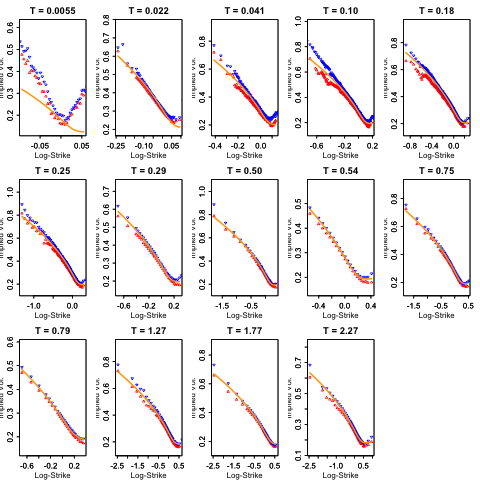

In [40]:
%%R

res110915 <- plotIvols(spxIvols110915,ssviFit110915)

Figure 26: SSVI fit to SPX options as of 15-Sep-2011 (the day before triple-witching).

###SSVI fit to 15-Sep-2011 data: Mar-2012 detail

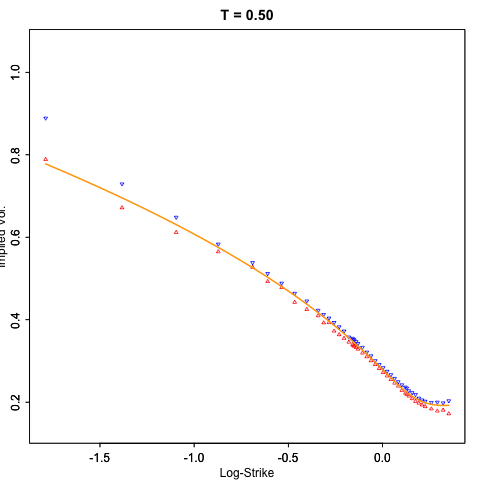

In [41]:
%%R

tmp <- plotIvols(spxIvols110915,ssviFit110915,slices=8)

Figure 27: SSVI fit to Mar-2012 smile as of 15-Sep-2011.

###Remarks on the SSVI fits

- The 2-parameter (for the whole surface) SSVI fit quality is overall extremely high, only slightly inferior to the full SVI fit with 5 parameters for each slice.


- For emphasis, the skew term structure function $\varphi(.)$ is assumed to be fixed, independent of time.
    - Only the parameters $\rho_t$ and $\eta_t$ are allowed to depend on time.



### 3D plot of SSVI local variance surface

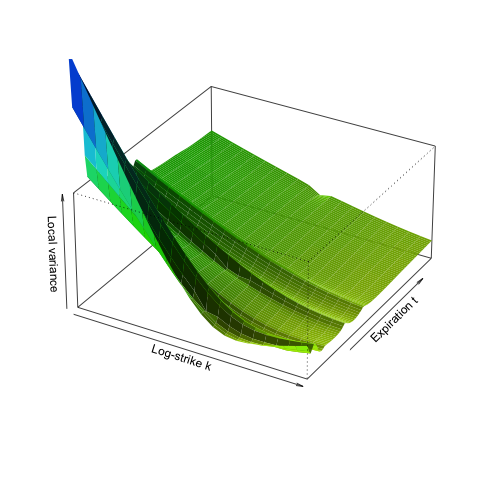

In [42]:
%%R

k <- seq(-.2,.2,.02) # Vector of log-strikes
t <- seq(0.04,1.72,0.02) # Vector of times

z <- sapply(t,function(tt){sviLocalVar(ssviFit110915,texp110915,k,tt)})

# Add colors
nbcol <- 100;
color <- rainbow(nbcol,start=.2,end=.6);
nrz <- nrow(z)
ncz <- ncol(z)
# Compute the z-value at the facet centres
zfacet <- z[-1, -1] + z[-1, -ncz] + z[-nrz, -1] + z[-nrz, -ncz]
# Recode facet z-values into color indices
facetcol <- cut(zfacet, nbcol);

# Generate 3D plot
persp(k, t, z, col=color[facetcol], phi=30, theta=30, 
    r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=20,ticktype="simple",
    shade=.8,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Local variance",zlim=c(0,.2));

Figure 28: Local variance surface corresponding to the SSVI fit (ssviFit110915).

### Generalization of SSVI

[Guo et al.]<sup id="cite_ref-GJMN" class="reference"><a href="#cite_note-GJMN"><span>[</span>5<span>]</span></a></sup> consider the following generalization of SSVI:

<a name="eq1:ssvi"></a>(1)
$$
\sigma_{\BS}^2\,T = \theta\,\Psi\left(\varphi(\theta)\,k\right) \text{ for all } k \in \mathbb{R}, t \geq 0.
$$

With various regularity assumptions, they establish necessary and sufficient conditions for this surface to be free of static arbitrage.


Define 

$$
F(z) := z\,\frac{\Psi'(z)}{\Psi(z)}, \quad f(u) := u\,\frac{\varphi'(u)}{\varphi(u)}
$$

### Conditions for no calendar spread arbitrage

<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
￼￼Proposition 3.1</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>

Let $\theta_\infty = \lim_{t \uparrow \infty} \theta_t$. The generalized SSVI surface [(1)](#eq1:gssvi) is free of calendar spread
arbitrage if and only if

<br>
<br>

1.  $\theta$ is non-decreasing;

<br>
<br>

2.  $1+F(z)\,f(u) \geq 0$ for any $z \in \mathbb{R}$ and $u \in (0, \theta_\infty)$. 

<br>
<br>


</div>

</blockquote>

### Conditions for no butterfly spread arbitrage

Define 
$$
Z_+(u) = \left\{ z \in \mathbb{R}: \frac 1 {4\,u}\,\left( \frac{\Psi'(z)^2}{\Psi(z)} - 2\,\Psi''(z)\right) + \frac{\Psi'(z)^2}{16} >0\right\}.
$$


<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
￼￼Proposition 4.2</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>


The generalized SSVI surface [(1)](#eq1:gssvi) is free of butterfly
arbitrage if and only if

<br>
<br>


$$
(u\,\varphi(u))^2 \leq \inf_{z \in Z_+(u)}\,\frac{\left(  1- \frac{z\,\Psi'(z)}{2\,\Psi(z)}\right)^2}{\frac 1 {4\,u}\,\left( \frac{\Psi'(z)^2}{\Psi(z)} - 2\,\Psi''(z)\right) + \frac{\Psi'(z)^2}{16}}.
$$ 

<br>
<br>


</div>

</blockquote>

### Remarks

- Proposition 4.2 is not easy to check and is the wrong way round.
    - We think we know $\varphi(u)$ and would like to know what kind of $\Psi$ would be consistent with $\varphi$.
    
    
    
- In the special case of SSVI,


$$
\Psi(z) = \frac 12\,\left\{ 1+\rho\,z + \sqrt{z^2+2\,\rho\,z + 1}  \right\}.
$$


- A couple of non-SSVI example smiles $\Psi(z)$ are given in the paper but these are symmetric in $z$ and so not applicable to equity markets.

###Alternative approaches

There is of course no *a priori* reason why a parametric functional form such as SSVI or SVI should fit observed volatility surfaces, though in practice, the fit is often pretty good.

- [Matthias Fengler]<sup id="cite_ref-Fengler" class="reference"><a href="#cite_note-Fengler"><span>[</span>3<span>]</span></a></sup> suggests cubic spline interpolation of call option prices.
    - Butterfly arbitrage is precluded by imposing that the second derivatives be non-negative at the knot points.
    - Calendar-spread arbitrage is eliminated by working backwards from the last expiry to the first, and solving a quadratic program at each step.
    - It seems that this method should give better fits, but it is complicated and the resulting local volatility surface will typically be very rough.
    
    
- [Andreasen and Huge]<sup id="cite_ref-AndreasenHuge" class="reference"><a href="#cite_note-AndreasenHuge"><span>[</span>1<span>]</span></a></sup>, present a clever method using finite differences to achieve no-arbitrage interpolation of a discrete set of option prices.
    -  The advantage is obviously that the fitting error should be very small (provided there is no arbitrage in the input prices).
    - The disadvantage is once again that the resulting local volatility surface is typically very rough.
    

  

  
    
- The algorithm of [Bachem, Drimus and Farkas]<sup id="cite_ref-Bachem" class="reference"><a href="#cite_note-Bachem"><span>[</span>2<span>]</span></a></sup> mixes elements of the Andreasen-Huge and Fengler approaches.  It slso shows explicitly how to take discrete dividends into account.

To quote from [Bachem, Drimus and Farkas]:

 >There exists an inherent trade-off between the smoothness of the implied volatility surface – or of the risk-neutral densities – and the quality of fit to observed market quotes. While a parametric approach may yield very smooth implied volatilities, it may be difficult to control how far out- side the bid-offer quotes the interpolation departs. On the other hand, a non-parametric approach may lead to very irregular implied risk-neutral densities. Neither of these issues is desirable. 

### Summary

- The construction we have presented shows how to fit SVI to the volatility surface whilst guaranteeing no-static-arbitrage.


- The SSVI parameterization allows us to summarize the shape of the whole volatility surface in a very straightforward way with very few parameters.
    - Invaluable in particular for analysis of volatility surface dynamics.


- The fitting code is all yours!

### References


<div class="reflist" style="list-style-type: decimal;">
<ol>

<li id="cite_note-AndreasenHuge"><span class="mw-cite-backlink"><b><a href="#cite_ref-AndreasenHuge">^</a></b></span> Jesper Andreasen and Brian Huge, Volatility interpolation,
<span>*Risk Magazine*</span>, 86–89
(March 2011).</li>

<li id="cite_note-Bachem"><span class="mw-cite-backlink"><b><a href="#cite_ref-Bachem">^</a></b></span>
O. Bachem, G. Drimus and W. Farkas,  Smooth and bid-offer compliant volatility surfaces under general dividend streams,
<span>*Quantitative Finance*</span>, <span>**13**</span>(11), 1801-1812, (2013).</li>

<li id="cite_note-Fengler"><span class="mw-cite-backlink"><b><a href="#cite_ref-Fengler">^</a></b></span> Matthias R. Fengler, Arbitrage-free smoothing of the implied volatility surface,
<span>*Quantitative Finance*</span>, <span>**9**</span>(4), 417–428 (2009).</li>


<li id="cite_note-GatheralJacquierSSVI"><span class="mw-cite-backlink"><b><a href="#cite_ref-GatheralJacquierSSVI">^</a></b></span>  Jim Gatheral and Antoine Jacquier, Arbitrage-free SVI volatility
surfaces, <span>*Quantitative Finance*</span> <span>**14**</span>(1) 59-71 (2014).</li>

<li id="cite_note-GJMN"><span class="mw-cite-backlink"><b><a href="#cite_ref-GJMN">^</a></b></span>  Gaoyue Guo, Antoine Jacquier, Claude Martini and Leo Neufcourt, Generalised arbitrage-free SVI volatility surfaces. *Available at SSRN* 2167263 (2012).

</ol>